<a href="https://colab.research.google.com/github/Rontim/GPU-Parallel-Processing-AI/blob/main/gpu_programming/neural_network_from_scratch_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Phase 3: Neural Network From Scratch (on GPU with CuPy)

In this phase, we build a simple neural network **from scratch** using **CuPy**, which allows us to perform all operations directly on the GPU. No high-level libraries — we’re building it from the ground up!


## 🎯 Objective

- Train a **binary classifier** using a fully connected neural network.
- All matrix operations (forward pass, loss, gradients, updates) are done using **CuPy** on the GPU.


## 🪄 Step 1: Generate Toy Classification Data (on CPU)

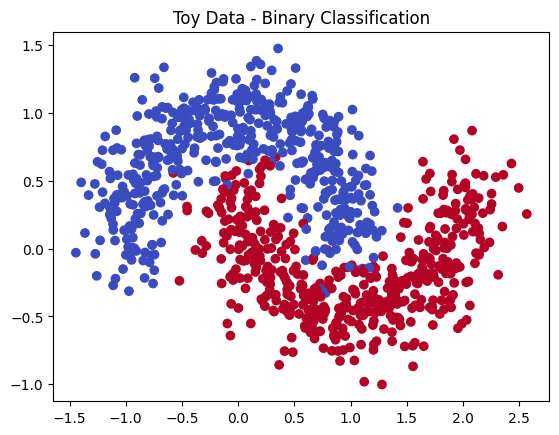

In [3]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=1000, noise=0.2, random_state=42)
X = X.astype(np.float32)
y = y.reshape(-1, 1).astype(np.float32)

plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap='coolwarm')
plt.title("Toy Data - Binary Classification")
plt.show()

## 🚀 Step 2: Move Data to GPU (CuPy Tensors)

In [4]:
import cupy as cp

X_gpu = cp.asarray(X)
y_gpu = cp.asarray(y)

## 🧱 Step 3: Initialize Network Parameters

In [5]:
n_input = 2
n_hidden = 16
n_output = 1

W1 = cp.random.randn(n_input, n_hidden) * cp.sqrt(2. / n_input)
b1 = cp.zeros((1, n_hidden))

W2 = cp.random.randn(n_hidden, n_output) * cp.sqrt(2. / n_hidden)
b2 = cp.zeros((1, n_output))


## 🔁 Step 4: Define Forward Pass

In [10]:
def sigmoid(x):
    return 1 / (1 + cp.exp(-x))

def forward(X):
    z1 = X @ W1 + b1
    a1 = cp.tanh(z1)
    z2 = a1 @ W2 + b2
    y_pred = sigmoid(z2)
    return y_pred, a1


## 🎯 Step 5: Binary Cross Entropy Loss

In [11]:
def binary_cross_entropy(y_pred, y_true):
    eps = 1e-8
    return -cp.mean(y_true * cp.log(y_pred + eps) + (1 - y_true) * cp.log(1 - y_pred + eps))


## 🔁 Step 6: Backpropagation

In [12]:
def backward(X, y_true, y_pred, a1):
    m = X.shape[0]

    dz2 = y_pred - y_true
    dW2 = a1.T @ dz2 / m
    db2 = cp.sum(dz2, axis=0, keepdims=True) / m

    da1 = dz2 @ W2.T
    dz1 = da1 * (1 - cp.tanh(a1) ** 2)
    dW1 = X.T @ dz1 / m
    db1 = cp.sum(dz1, axis=0, keepdims=True) / m

    return dW1, db1, dW2, db2


## 🏋️ Step 7: Training Loop

In [13]:
lr = 0.1
epochs = 1000

for epoch in range(epochs):
    y_pred, a1 = forward(X_gpu)
    loss = binary_cross_entropy(y_pred, y_gpu)

    dW1, db1, dW2, db2 = backward(X_gpu, y_gpu, y_pred, a1)

    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.8685
Epoch 100, Loss: 0.3237
Epoch 200, Loss: 0.3076
Epoch 300, Loss: 0.3012
Epoch 400, Loss: 0.2958
Epoch 500, Loss: 0.2901
Epoch 600, Loss: 0.2837
Epoch 700, Loss: 0.2766
Epoch 800, Loss: 0.2689
Epoch 900, Loss: 0.2605


## Step 8: Visualize Decision Boundary

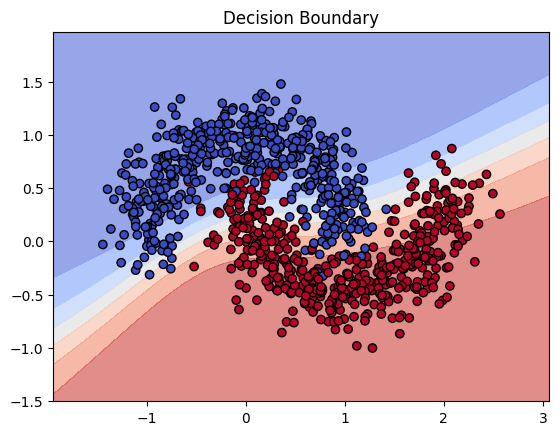

In [14]:
def plot_decision_boundary(X, y, pred_func):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = cp.asarray(np.c_[xx.ravel(), yy.ravel()])
    preds, _ = pred_func(grid)
    preds = cp.asnumpy(preds.reshape(xx.shape))

    plt.contourf(xx, yy, preds, cmap='coolwarm', alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap='coolwarm', edgecolors='k')
    plt.title("Decision Boundary")
    plt.show()

plot_decision_boundary(X, y, forward)
